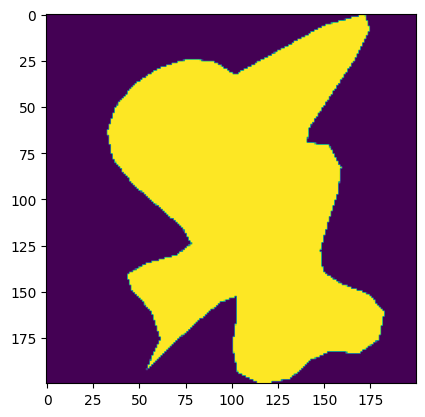

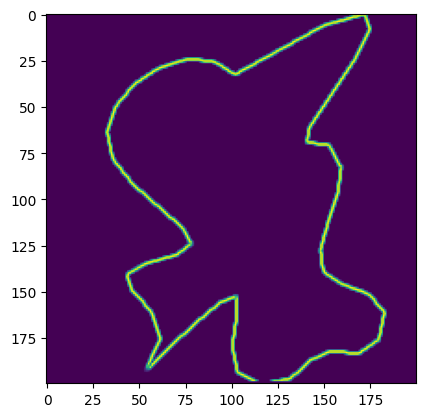

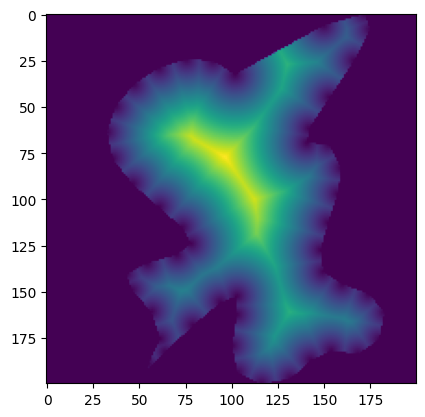

In [2]:
from torch_contour.torch_contour import Contour_to_distance_map, Contour_to_mask, Draw_contour
import torch
import matplotlib.pyplot as plt

polygons1 = torch.tensor([[[[0.1640, 0.5085],
          [0.1267, 0.4491],
          [0.1228, 0.3772],
          [0.1461, 0.3027],
          [0.1907, 0.2356],
          [0.2503, 0.1857],
          [0.3190, 0.1630],
          [0.3905, 0.1774],
          [0.4595, 0.2317],
          [0.5227, 0.3037],
          [0.5774, 0.3658],
          [0.6208, 0.3905],
          [0.6505, 0.3513],
          [0.6738, 0.2714],
          [0.7029, 0.2152],
          [0.7461, 0.2298],
          [0.8049, 0.2828],
          [0.8776, 0.3064],
          [0.9473, 0.2744],
          [0.9606, 0.2701],
          [0.9138, 0.3192],
          [0.8415, 0.3947],
          [0.7793, 0.4689],
          [0.7627, 0.5137],
          [0.8124, 0.5142],
          [0.8961, 0.5011],
          [0.9696, 0.5158],
          [1.0000, 0.5795],
          [0.9858, 0.6581],
          [0.9355, 0.7131],
          [0.9104, 0.7682],
          [0.9184, 0.8406],
          [0.8799, 0.8974],
          [0.8058, 0.9121],
          [0.7568, 0.8694],
          [0.7305, 0.7982],
          [0.6964, 0.7466],
          [0.6378, 0.7394],
          [0.5639, 0.7597],
          [0.4864, 0.7858],
          [0.4153, 0.7953],
          [0.3524, 0.7609],
          [0.3484, 0.7028],
          [0.3092, 0.7089],
          [0.2255, 0.7632],
          [0.1265, 0.8300],
          [0.0416, 0.8736],
          [0.0000, 0.8584],
          [0.0310, 0.7486],
          [0.1640, 0.5085]]]], dtype=torch.float32)  


Mask = Contour_to_mask(200)
Draw = Draw_contour(200)
Dmap = Contour_to_distance_map(200)


plt.imshow(Mask(polygons1).cpu().detach().numpy()[0,0])
plt.show()
plt.imshow(Draw(polygons1).cpu().detach().numpy()[0,0])
plt.show()
plt.imshow(Dmap(polygons1).cpu().detach().numpy()[0,0])
plt.show()

In [44]:
import numpy as np

a = torch.tensor([[[ [  0.  ,   0.  ],[  0.3 ,   0.  ],[  1.25,  -0.1 ],
              [  2.1 ,  -0.9 ],[  2.85,  -2.3 ],[  3.8 ,  -3.95],
              [  5.  ,  -5.75],[  6.4 ,  -7.8 ],[  8.05,  -9.9 ],
              [  9.9 , -11.6 ],[ 12.05, -12.85],[ 14.25, -13.7 ],
              [ 16.5 , -13.8 ],[ 19.25, -13.35],[ 21.3 , -12.2 ],
              [ 22.8 , -10.5 ],[ 23.55,  -8.15],[ 22.95,  -6.1 ],
              [ 21.35,  -3.95],[ 19.1 ,  -1.9 ]]]])
print(a.shape)



torch.Size([1, 1, 20, 2])


In [48]:
import numpy as np

def curvature(contour):
    
    """
    Computes the curvature of a given contour.

    This function calculates the curvature of a 2D contour represented as a tensor.
    The input contour is extended at the beginning and end to handle boundary conditions
    for gradient computation. The function then computes the velocity and acceleration
    of the contour points, and finally calculates the curvature using these values.

    Parameters:
    -----------
    contour : torch.Tensor
        A tensor of shape (B, N, K, 2), where:
        - B is the batch size
        - N is the number of contours in a batch
        - K is the number of points in each contour
        - 2 represents the x and y coordinates of each point

    Returns:
    --------
    torch.Tensor
        A tensor of shape (B, N, K-6) representing the curvature of each point
        in the contour, excluding the boundary points used for padding.

    Example:
    --------
    >>> import torch
    >>> contour = torch.rand(1, 1, 10, 2)  # Example contour with random points
    >>> curv = curvature(contour)
    >>> print(curv.shape)
    torch.Size([1, 1, 4])
    """

    contour = torch.cat([contour[:,:,-3:, :], contour, contour[:,:,:3,:]],dim=-2)
    b,n,k,_ = contour.shape
    contour = contour.reshape(b*n, k, -1)
    velocity = torch.gradient(contour, dim =1)[0]
    ds_dt = torch.norm(velocity,dim = -1)
    accel = torch.gradient(velocity, dim=1)[0]
    curvature = torch.abs(accel[:,:,0] * velocity[:,:,1] - velocity[:,:,0] * accel[:,:,1]) / torch.sum(velocity**2,dim=-1)**1.5
    curvature = curvature.reshape(b,n,k,-1)
    curvature = curvature[:,:,3:-3,0]


    return curvature 


torch.Size([1, 1, 20])